In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


### Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='04:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=12)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 04:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.189:45861 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.189:45861,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)

wmts = []

sigma = 36.775

In [8]:
for (t, file) in enumerate(datafiles[-10:]): 
    print(file)
    ds = xr.open_mfdataset(
        file,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    ds = ds.fillna(0.)

    grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
    grid._ds = grid._ds.assign_coords({
        "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
        "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
    })
    grid = xwmt.add_gridcoords(
        grid,
        {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
        {"Z_target": "extend"}
    )

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
    
        budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
        # budgets_dict = xbudget.load_yaml(datadir("../../MOM6_AABW.yaml"))

        xbudget.collect_budgets(grid, budgets_dict)
        
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict, 
        ) #if region not passed, the whole globe is taken
        wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                        integrate=False, along_section=False)
        
        wmt = wmb.wmt.sel(sigma2_l_target = sigma, method = "nearest")

        
        variables = ["surface_ocean_flux_advective_negative_rhs_heat", 
                     "surface_ocean_flux_advective_negative_rhs_salt", 
                     "surface_exchange_flux_heat", 
                     "surface_exchange_flux_salt", 
                     "frazil_ice_heat", 
                     "bottom_flux_heat",
                     "boundary_fluxes", 
                     "mass_tendency", 
                     "diffusion_heat", 
                     "diffusion_salt",
                     "spurious_numerical_mixing",
                     "convergent_mass_transport"
                     ]
        
        wmt = wmt[variables]
        wmt = wmt.compute()
        
        wmts += [1 * wmt]

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2050-2054.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2055-2059.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2060-2064.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2065-2069.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2070-2074.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2075-2079.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2080-2084.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2

In [9]:
wmts_ds = xr.concat(wmts, dim = "time")

In [10]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
wmts_ds.to_netcdf(savedir + f"Global_Surface_Advection_and_Tendency_sigma_{sigma}.nc")

In [13]:
savedir + f"Global_Surface_Advection_and_Tendency_sigma_{sigma}.nc"

'/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/Global_Surface_Advection_and_Tendency_sigma_36.775.nc'

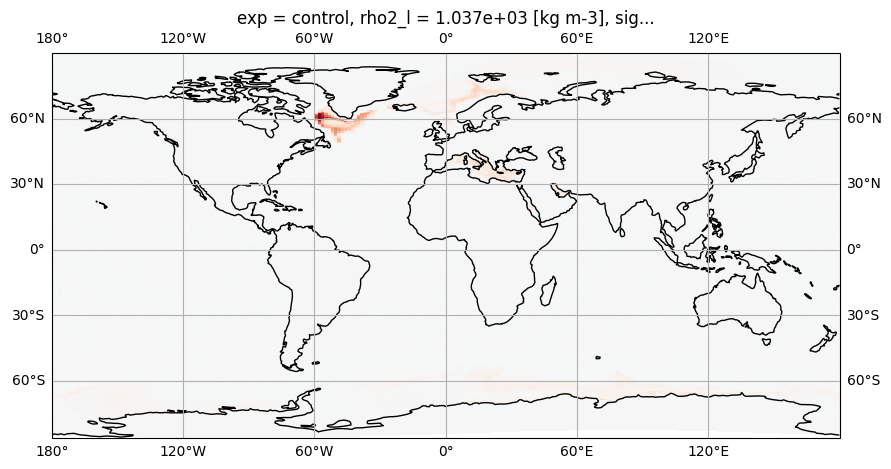

In [12]:
fig, ax = plt.subplots(figsize = (12, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
wmts_ds.isel(exp = 1).mean("time").boundary_fluxes.plot(ax = ax, x = "geolon", y = "geolat", 
                                                                   transform=ccrs.PlateCarree(), add_colorbar = False)

ax.coastlines()
ax.gridlines( draw_labels=True)